In [1]:
from IPython.display import Latex
import numpy as np
import scipy
from numpy.random import randn
import numpy as np
from scipy.linalg import sqrtm
import math  
import matplotlib.pyplot as plt

In [2]:
def parameter_sigmapoints(n,alpha,beta,kappa):
    '''
    n : dimension of state vector
    alpha,beta,kappa : manually set up patamaters
    wm : weight matrix for calculating mean
    wc : weight matrix for calculating variance
    U : a parameter for computation convenience 
    '''
    lamb=alpha**2*(n+kappa)-n
    wm=[lamb/(n+lamb)]
    wc=[(lamb/(lamb+n))+(1-alpha**2+beta)]
    for i in range(2*n):
        wm.append(1/(2*(n+lamb)))
        wc.append(1/(2*(n+lamb)))
    U=math.sqrt(n+lamb)
    U=np.array([U])
    wm=np.array([wm])
    wc=np.array([wc])
    return wm,wc,U

In [3]:
#generazation of sigma ponits
def generate_sigmapoints(xEst, PEst, U):
    '''
    xEst:mean of initial data
    PEst:variance of initial data 
    U:U=sqrt(n+lamb)
    '''
    sigma = xEst
    Psqrt = scipy.linalg.sqrtm(PEst)
    
    #Psqrt=scipy.linalg.cholesky(PEst)
    n = len(xEst[:, 0])
    
    for i in range(n):
        sigma = np.hstack((sigma, xEst + U * Psqrt[:, i:i + 1]))
    for i in range(n):
        sigma = np.hstack((sigma, xEst - U * Psqrt[:, i:i + 1]))
    return sigma
    

def transform_sigma_motion(sigma):
    """
        Sigma Points prediction with motion model 
    """
    for i in range(sigma.shape[1]):
        sigma[:, i:i + 1] = f(sigma[:, i:i + 1],dt)

    return sigma

def transform_sigma_observation(sigma):
    """
        Sigma Points prediction with observation model
    """
    sigma_obs=np.zeros((2,sigma.shape[1]))
    for i in range(sigma.shape[1]): 
        sigma_obs[:,i] = h_radar(sigma[:, i])
    return sigma_obs

def covariance_prior(x, sigma, wc, Pi):
    ''' 
    
    '''
    nSigma = sigma.shape[1]
   # print('nSigma',nSigma)
    d = sigma - x[0:sigma.shape[0]]
   # print('d.shape ist',d.shape)
    P = Pi
    #print('P',P)
    for i in range(nSigma):
        P = P + wc[0, i] * d[:, i:i + 1] @ d[:, i:i + 1].T
        #print(P)
    return P


def calc_pxz(sigma, x, z_sigma, zb, wc):
    '''
    
    '''
    nSigma = sigma.shape[1]
    dx = sigma - x
    dz = z_sigma - zb[0:2]
    P = np.zeros((dx.shape[0], dz.shape[0]))

    for i in range(nSigma):
        P = P + wc[0, i] * dx[:, i:i + 1] @ dz[:, i:i + 1].T
    return P


In [4]:
def ukf_estimation(xEst, PEst, z, wm, wc, gamma):
    '''
    z: observation with noise 
    wm, wc, gamma: constant parameters
    '''
    #  Predict process
    # generate sigma points
    sigma = generate_sigmapoints(xEst, PEst, gamma)
    sigma= transform_sigma_motion(sigma)
    #prediction of mean of input 
    xPred = (wm @ sigma.T).T
    # estimate of covariance 
    PPred = covariance_prior(xPred, sigma, wc, Q)
    
    #  Update process
    
    #  generate new sigma points after prediction 
    sigma = generate_sigmapoints(xPred, PPred, gamma)
    # transform sigma points with observation model    
    z_sigma = transform_sigma_observation(sigma)
    # mean
    zPred = (wm @ z_sigma.T).T
    #  Pz_matrix  
    st = covariance_prior(zPred, z_sigma, wc, R)
    Pxz = calc_pxz(sigma, xPred, z_sigma, zPred, wc)
    # kalman gain
    K = Pxz @ np.linalg.inv(st)
    y = z - zPred
    # update the estimate value：  
    xEst = xPred + K @ y
    # update the covariance：
    PEst = PPred - K @ st @ K.T
    return xEst, PEst

First we design the state transition function.

We will assume that the aircraft is flying at a constant altitude. In this situation we design three state vectors as follows.

$$\mathbf x = \begin{bmatrix}\mathtt{distance} \\\mathtt{velocity}\\ \mathtt{altitude}\end{bmatrix}=    \begin{bmatrix}x \\ \dot x\\ y\end{bmatrix}$$

Next we design the measurement function. Using radar we can get the range and elevation angle information about the tracking target. So we convert the position and velocity of the targey into the elevation angle and range from the radar station, which is the nonlinear function. 

Range is computed using the equation following.

$$\text{range} = \sqrt{(x_\text{ac} - x_\text{radar})^2 + (y_\text{ac} - y_\mathtt{radar})^2}$$

The elevation angle $\epsilon$ is the arctangent of $y/x$:

$$\epsilon = \tan^{-1}{\frac{y_\mathtt{ac} - y_\text{radar}}{x_\text{ac} - x_\text{radar}}}$$


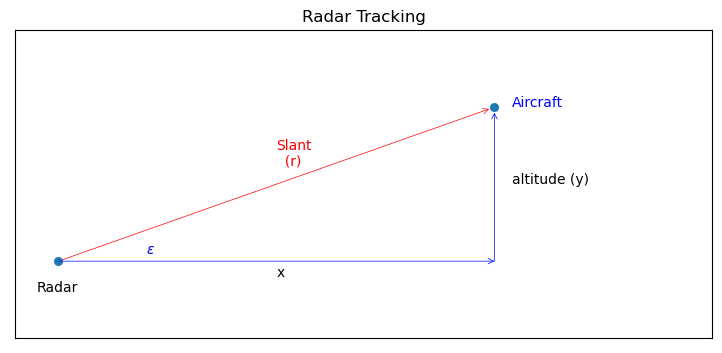


Q.size (3, 3)
Uist [0.17320508]
wm is [[-99.          16.66666667  16.66666667  16.66666667  16.66666667
   16.66666667  16.66666667]]
wc [[-96.01        16.66666667  16.66666667  16.66666667  16.66666667
   16.66666667  16.66666667]]


<ipython-input-29-439f76da1644>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  slant_range = math.sqrt(dx**2 + dy**2)
<ipython-input-29-439f76da1644>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  elevation_angle = math.atan2(dy, dx)


Text(0, 0.5, 'altitude(m)')

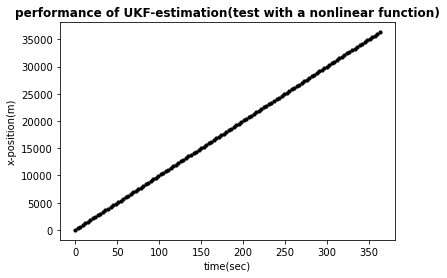

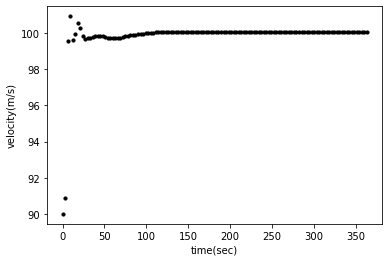

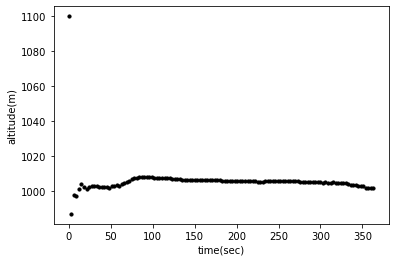

In [29]:
def f(x, dt):
    """ state transition function for a constant velocity 
    aircraft with state vector [x, velocity, altitude]'"""
    
    F = np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]], dtype=float)
    return F @ x

import math
def  h_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    elevation_angle = math.atan2(dy, dx)
    return [slant_range, elevation_angle]

h_radar.radar_pos = (0, 0)

from numpy.linalg import norm
from math import atan2

class RadarStation:
    
    def __init__(self, pos, range_std, elev_angle_std):   
        self.pos = np.asarray(pos)       
        self.range_std = range_std
        self.elev_angle_std = elev_angle_std

    
    def reading_of(self, ac_pos):
        """ Returns (range, elevation angle) to aircraft. 
        Elevation angle is in radians.
        """
        
        diff = np.subtract(ac_pos, self.pos) # aircraft position - radar position  2-dimensional position vector [x,y]
        rng = norm(diff)  #range    slant distance 
        brg = atan2(diff[1], diff[0])  # elevation angle  
        return rng, brg 


    def noisy_reading(self, ac_pos):
        """ Compute range and elevation angle to aircraft with 
        simulated noise"""
        
        rng, brg = self.reading_of(ac_pos)       
        rng += randn() * self.range_std   #add measurement noise 
        brg += randn() * self.elev_angle_std  
        return rng, brg       

class ACSim:   
    def __init__(self, pos, vel, vel_std):  
        self.pos = np.asarray(pos, dtype=float) 
        self.vel = np.asarray(vel, dtype=float) 
        self.vel_std = vel_std        
        
    def update(self, dt):
        """ Compute and returns next position. Incorporates 
        random variation in velocity. """
        
        dx = self.vel*dt + (randn() * self.vel_std) * dt      
        self.pos += dx    
        
        return self.pos
    
import math


dt = 3. # 12 seconds between readings 
range_std = 5 # meters 
elevation_angle_std = math.radians(0.5)
ac_pos = (0., 1000.) #positon of aircraft
ac_vel = (100., 0.) # velocity 
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos

#points = MerweScaledSigmaPoints(n=3, alpha=.1, beta=2., kappa=0.)
#kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, points=points)
Q=np.zeros((3,3))
Q[0:2, 0:2] =np.random.normal(0,0.1, size=(2,2)) 
Q[2,2] = 0.1 

print('Q.size',Q.shape)
R = np.diag([range_std**2, elevation_angle_std**2])
# R is  mesurement noise matrix (sensor measurement)


xEst = np.array([0., 90., 1100.]).reshape(3,1)  # initial x

#print('initial.xEst.size',xEst.shape)

PEst = np.diag([300**2, 30**2, 150**2])  


np.random.seed(200)
pos = (0, 0)
radar = RadarStation(pos, range_std, elevation_angle_std)  

n=3
alpha=.1
beta=2.
kappa=0 
wm, wc, U = parameter_sigmapoints(n,alpha,beta,kappa)
print('Uist',U)
print('wm is',wm)
print('wc',wc)
ac = ACSim(ac_pos, (100, 0), 0.02)  
time = np.arange(0, 360+dt, dt)
hxEst = xEst
#print('initial hxEst',hxEst)
for i in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    z = np.array(r, dtype=float)
    z=z.reshape(2,1)
    sigma=generate_sigmapoints(xEst, PEst, U)
    xEst, PEst = ukf_estimation(xEst, PEst, z, wm, wc,U)
    hxEst = np.hstack((hxEst, xEst))
    #print(xEst)

time=np.arange(0, 363+dt, dt)
plt.figure(1)
plt.scatter(time,hxEst[0,:],color='black',s=10,label="nonlinear-Estimation")
plt.title('performance of UKF-estimation(test with a nonlinear function)',fontsize='large',fontweight='bold') 
plt.xlabel('time(sec)')
plt.ylabel('x-position(m)')

plt.figure(2)
plt.scatter(time,hxEst[1,:],color='black',s=10,label="nonlinear-Estimation")
plt.xlabel('time(sec)')
plt.ylabel('velocity(m/s)')

plt.figure(3)
plt.scatter(time,hxEst[2,:],color='black',s=10,label="nonlinear-Estimation")
plt.xlabel('time(sec)')
plt.ylabel('altitude(m)')
